In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [2]:
claude_df = pd.read_csv('../Data/qna_dataset_Claude3.5Sonnet_final.csv')
gpt35_df = pd.read_csv('../Data/qna_dataset_GPT3.5_final.csv') 
gpt4o_df = pd.read_csv('../Data/qna_dataset_GPT4o_final.csv')

In [3]:
claude_df['model'] = 'Claude_3.5'
gpt35_df['model'] = 'GPT_3.5'
gpt4o_df['model'] = 'GPT_4o'

In [5]:
all_data = pd.concat([claude_df, gpt35_df, gpt4o_df], ignore_index=True)

In [6]:
all_data['hallucination_numeric'] = all_data['hallucination_present'].astype(int)

print(f"Total observations: {len(all_data):,}")
print(f"Models: {list(all_data['model'].unique())}")
print(f"Outcome variable: hallucination_present (0 = factual, 1 = hallucination)")
print()

Total observations: 1,200
Models: ['Claude_3.5', 'GPT_3.5', 'GPT_4o']
Outcome variable: hallucination_present (0 = factual, 1 = hallucination)



### DESCRIPTIVE STATISTICS (BASIC COMPARISON)

In [7]:
model_summary = all_data.groupby('model').agg({
    'hallucination_numeric': ['count', 'sum', 'mean', 'std']
}).round(4)

model_summary.columns = ['N', 'Hallucinations', 'Rate', 'Std']
model_summary['Percentage'] = (model_summary['Rate'] * 100).round(2)
model_summary['SE'] = (model_summary['Std'] / np.sqrt(model_summary['N'])).round(4)

print("Hallucination rates by model:")
print(model_summary[['N', 'Hallucinations', 'Percentage', 'SE']])
print()

Hallucination rates by model:
              N  Hallucinations  Percentage      SE
model                                              
Claude_3.5  400              49       12.25  0.0164
GPT_3.5     400              75       18.75  0.0195
GPT_4o      400              47       11.75  0.0161



In [9]:
# Calculate 95% confidence intervals
print("95% Confidence Intervals:")
for model in all_data['model'].unique():
    data = all_data[all_data['model'] == model]
    rate = data['hallucination_numeric'].mean()
    n = len(data)
    se = np.sqrt(rate * (1 - rate) / n)
    ci_lower = rate - 1.96 * se
    ci_upper = rate + 1.96 * se
    print(f"{model}: {rate*100:.1f}% (95% CI: {ci_lower*100:.1f}% - {ci_upper*100:.1f}%)")


95% Confidence Intervals:
Claude_3.5: 12.2% (95% CI: 9.0% - 15.5%)
GPT_3.5: 18.8% (95% CI: 14.9% - 22.6%)
GPT_4o: 11.8% (95% CI: 8.6% - 14.9%)


In [10]:
gpt4o_rate = all_data[all_data['model'] == 'GPT_4o']['hallucination_numeric'].mean()
gpt35_rate = all_data[all_data['model'] == 'GPT_3.5']['hallucination_numeric'].mean()
claude_rate = all_data[all_data['model'] == 'Claude_3.5']['hallucination_numeric'].mean()

difference = gpt35_rate - gpt4o_rate
relative_improvement = (difference / gpt35_rate) * 100

In [12]:
print("🎯 PRIMARY RESEARCH QUESTION ANSWER:")
print(f"GPT-3.5 (older model): {gpt35_rate*100:.1f}% hallucination rate")
print(f"GPT-4o (newer model): {gpt4o_rate*100:.1f}% hallucination rate")
print(f"Absolute difference: {difference*100:.1f} percentage points")
print(f"Relative improvement: {relative_improvement:.1f}% reduction")
print(f"Answer: {'YES' if gpt4o_rate < gpt35_rate else 'NO'} - newer model has {'lower' if gpt4o_rate < gpt35_rate else 'higher'} hallucination rate")

🎯 PRIMARY RESEARCH QUESTION ANSWER:
GPT-3.5 (older model): 18.8% hallucination rate
GPT-4o (newer model): 11.8% hallucination rate
Absolute difference: 7.0 percentage points
Relative improvement: 37.3% reduction
Answer: YES - newer model has lower hallucination rate


### STATISTICAL SIGNIFICANCE TEST

In [13]:
contingency = pd.crosstab(all_data['model'], all_data['hallucination_numeric'], margins=True)
print("Contingency Table:")
print(contingency)

Contingency Table:
hallucination_numeric     0    1   All
model                                 
Claude_3.5              351   49   400
GPT_3.5                 325   75   400
GPT_4o                  353   47   400
All                    1029  171  1200


In [15]:
chi2_stat, p_val, dof, expected = chi2_contingency(contingency.iloc[:-1, :-1])
print("Chi-square test for overall model differences:")
print(f"Chi-square statistic: χ² = {chi2_stat:.4f}")
print(f"P-value: {p_val:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"Result: {'Statistically significant' if p_val < 0.05 else 'Not statistically significant'} at α = 0.05")

Chi-square test for overall model differences:
Chi-square statistic: χ² = 9.9841
P-value: 0.006792
Degrees of freedom: 2
Result: Statistically significant at α = 0.05


### LOGISTIC REGRESSION

In [16]:
all_data['is_gpt4o'] = (all_data['model'] == 'GPT_4o').astype(int)
all_data['is_claude'] = (all_data['model'] == 'Claude_3.5').astype(int)

print("Reference category: GPT-3.5 (older model)")
print("Comparison categories: GPT-4o (newer), Claude 3.5")

Reference category: GPT-3.5 (older model)
Comparison categories: GPT-4o (newer), Claude 3.5


In [17]:
# Fit basic logistic regression
try:
    basic_model = logit('hallucination_numeric ~ is_gpt4o + is_claude', data=all_data).fit(disp=0)
    
    print("LOGISTIC REGRESSION RESULTS:")
    print(basic_model.summary().tables[1])
    print()
    
    # Calculate and interpret odds ratios (Week 9 content)
    print("ODDS RATIOS INTERPRETATION:")
    print("=" * 35)
    
    odds_ratios = np.exp(basic_model.params)
    conf_int_or = np.exp(basic_model.conf_int())
    
    # Focus on GPT-4o vs GPT-3.5 (primary research question)
    if 'is_gpt4o' in odds_ratios.index:
        or_gpt4o = odds_ratios['is_gpt4o']
        ci_lower = conf_int_or.loc['is_gpt4o', 0]
        ci_upper = conf_int_or.loc['is_gpt4o', 1]
        p_val_gpt4o = basic_model.pvalues['is_gpt4o']
        
        print("🎯 PRIMARY COMPARISON: GPT-4o vs GPT-3.5")
        print(f"Coefficient: {basic_model.params['is_gpt4o']:.4f}")
        print(f"Odds Ratio: {or_gpt4o:.3f}")
        print(f"95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")
        print(f"P-value: {p_val_gpt4o:.4f}")
        
        if or_gpt4o < 1:
            reduction = (1 - or_gpt4o) * 100
            print(f"Interpretation: GPT-4o has {reduction:.1f}% LOWER odds of hallucination")
            print(f"Statistical significance: {'***' if p_val_gpt4o < 0.001 else '**' if p_val_gpt4o < 0.01 else '*' if p_val_gpt4o < 0.05 else 'ns'}")
        else:
            increase = (or_gpt4o - 1) * 100
            print(f"Interpretation: GPT-4o has {increase:.1f}% HIGHER odds of hallucination")
        
        print(f"\n🔬 RESEARCH QUESTION ANSWER: {'YES' if or_gpt4o < 1 and p_val_gpt4o < 0.05 else 'NO'} - statistically significant improvement")
    
    # Also show Claude for completeness
    if 'is_claude' in odds_ratios.index:
        or_claude = odds_ratios['is_claude']
        p_val_claude = basic_model.pvalues['is_claude']
        
        print(f"\nClaude 3.5 vs GPT-3.5:")
        print(f"Odds Ratio: {or_claude:.3f}, P-value: {p_val_claude:.4f}")
    
    print(f"\nModel fit statistics:")
    print(f"AIC: {basic_model.aic:.2f}")
    print(f"Pseudo R²: {basic_model.prsquared:.3f}")
    print()

except Exception as e:
    print(f"Logistic regression failed: {e}")

LOGISTIC REGRESSION RESULTS:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4663      0.128    -11.447      0.000      -1.717      -1.215
is_gpt4o      -0.5500      0.201     -2.732      0.006      -0.945      -0.155
is_claude     -0.5026      0.199     -2.524      0.012      -0.893      -0.112

ODDS RATIOS INTERPRETATION:
🎯 PRIMARY COMPARISON: GPT-4o vs GPT-3.5
Coefficient: -0.5500
Odds Ratio: 0.577
95% CI: (0.389, 0.856)
P-value: 0.0063
Interpretation: GPT-4o has 42.3% LOWER odds of hallucination
Statistical significance: **

🔬 RESEARCH QUESTION ANSWER: YES - statistically significant improvement

Claude 3.5 vs GPT-3.5:
Odds Ratio: 0.605, P-value: 0.0116

Model fit statistics:
AIC: 979.09
Pseudo R²: 0.010



### CONTROLLING FOR CONFOUNDERS

In [18]:
domains = all_data['domain'].unique()
print(f"Controlling for domains: {list(domains)}")

Controlling for domains: ['General Knowledge', 'Science', 'History', 'Pop Culture', 'Healthcare']


In [19]:
for i, domain in enumerate(domains[1:], 1):  # Skip first as reference
    var_name = f"domain_{i}"
    all_data[var_name] = (all_data['domain'] == domain).astype(int)

domain_vars = [col for col in all_data.columns if col.startswith('domain_')]

In [20]:
control_formula = f"hallucination_numeric ~ is_gpt4o + is_claude + question_length + {' + '.join(domain_vars)}"

In [21]:
try:
    controlled_model = logit(control_formula, data=all_data).fit(disp=0)
    
    print(f"\nCONTROLLED MODEL:")
    print(f"Controls: Domain, question length")
    print()
    
    # Extract key results
    if 'is_gpt4o' in controlled_model.params.index:
        coef_controlled = controlled_model.params['is_gpt4o']
        or_controlled = np.exp(coef_controlled)
        p_controlled = controlled_model.pvalues['is_gpt4o']
        se_controlled = controlled_model.bse['is_gpt4o']
        
        ci_lower_controlled = np.exp(coef_controlled - 1.96 * se_controlled)
        ci_upper_controlled = np.exp(coef_controlled + 1.96 * se_controlled)
        
        print("GPT-4o vs GPT-3.5 (after controlling for confounders):")
        print(f"Odds Ratio: {or_controlled:.3f}")
        print(f"95% CI: ({ci_lower_controlled:.3f}, {ci_upper_controlled:.3f})")
        print(f"P-value: {p_controlled:.4f}")
        
        if or_controlled < 1:
            reduction_controlled = (1 - or_controlled) * 100
            print(f"Controlled effect: {reduction_controlled:.1f}% reduction in hallucination odds")
    
    print(f"\nControlled model fit: AIC = {controlled_model.aic:.2f}")
    print()

except Exception as e:
    print(f"Controlled model failed: {e}")



CONTROLLED MODEL:
Controls: Domain, question length

GPT-4o vs GPT-3.5 (after controlling for confounders):
Odds Ratio: 0.551
95% CI: (0.366, 0.831)
P-value: 0.0045
Controlled effect: 44.9% reduction in hallucination odds

Controlled model fit: AIC = 899.05



### MODEL SELECTION

In [22]:
models_to_test = {
    'Basic Model': 'hallucination_numeric ~ is_gpt4o + is_claude',
    'With Question Length': 'hallucination_numeric ~ is_gpt4o + is_claude + question_length',
    'With Domain Controls': control_formula
}

model_comparison = []

print("Comparing model specifications:")
for name, formula in models_to_test.items():
    try:
        model = logit(formula, data=all_data).fit(disp=0)
        
        # Extract GPT-4o effect
        gpt4o_or = np.exp(model.params.get('is_gpt4o', np.nan))
        gpt4o_p = model.pvalues.get('is_gpt4o', np.nan)
        
        model_comparison.append({
            'Model': name,
            'AIC': model.aic,
            'BIC': model.bic,
            'Pseudo_R2': model.prsquared,
            'GPT4o_OR': gpt4o_or,
            'GPT4o_p_value': gpt4o_p
        })
        
    except Exception as e:
        print(f"  {name}: Failed")

if model_comparison:
    comparison_df = pd.DataFrame(model_comparison)
    comparison_df = comparison_df.sort_values('AIC')
    
    print("\nModel comparison results:")
    print(comparison_df.round(4))
    
    best_model = comparison_df.iloc[0]
    print(f"\nBest model by AIC: {best_model['Model']}")
    print(f"In best model, GPT-4o OR = {best_model['GPT4o_OR']:.3f} (p = {best_model['GPT4o_p_value']:.4f})")


Comparing model specifications:

Model comparison results:
                  Model       AIC       BIC  Pseudo_R2  GPT4o_OR  \
2  With Domain Controls  899.0451  939.7657     0.1014    0.5511   
0           Basic Model  979.0947  994.3649     0.0098    0.5770   
1  With Question Length  979.1748  999.5351     0.0118    0.5764   

   GPT4o_p_value  
2         0.0045  
0         0.0063  
1         0.0062  

Best model by AIC: With Domain Controls
In best model, GPT-4o OR = 0.551 (p = 0.0045)


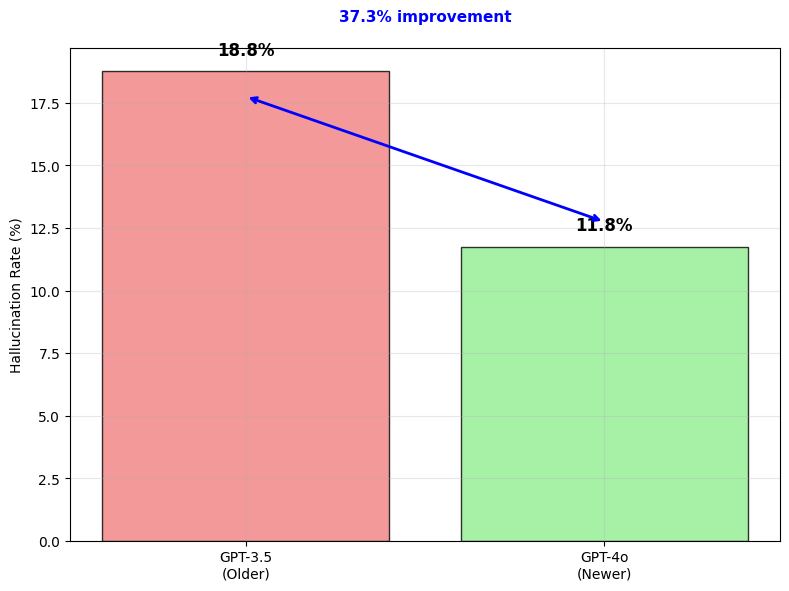

Primary Finding: GPT-4o shows 37.3% improvement over GPT-3.5


In [26]:
gpt4o_rate = all_data[all_data['model'] == 'GPT_4o']['hallucination_numeric'].mean()
gpt35_rate = all_data[all_data['model'] == 'GPT_3.5']['hallucination_numeric'].mean()
relative_improvement = ((gpt35_rate - gpt4o_rate) / gpt35_rate) * 100

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

models_ordered = ['GPT_3.5', 'GPT_4o']
rates_ordered = [gpt35_rate * 100, gpt4o_rate * 100]
colors = ['lightcoral', 'lightgreen']

bars = ax.bar(range(len(models_ordered)), rates_ordered, color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(models_ordered)))
ax.set_xticklabels(['GPT-3.5\n(Older)', 'GPT-4o\n(Newer)'])
ax.set_ylabel('Hallucination Rate (%)')
# ax.set_title('RQ2: Do Newer Models Hallucinate Less?\nDirect Comparison', fontsize=10, fontweight='bold')

# Add values on bars
for bar, rate in zip(bars, rates_ordered):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Add improvement annotation
improvement_text = f'{relative_improvement:.1f}% improvement'
ax.annotate('', xy=(0, rates_ordered[0] - 1), xytext=(1, rates_ordered[1] + 1),
            arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
ax.text(0.5, max(rates_ordered) + 2, improvement_text, ha='center', 
         color='blue', fontweight='bold', fontsize=11)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Primary Finding: GPT-4o shows {relative_improvement:.1f}% improvement over GPT-3.5")

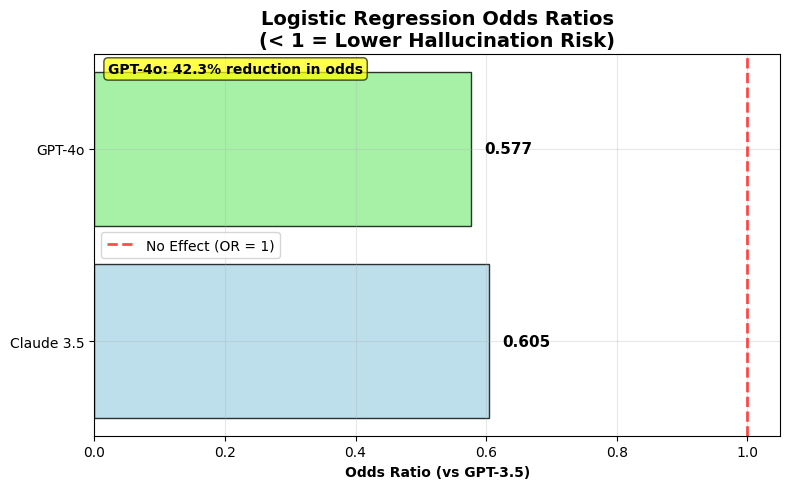

In [28]:
try:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    models_or = ['Claude 3.5', 'GPT-4o']
    or_values = [odds_ratios.get('is_claude', 1), odds_ratios.get('is_gpt4o', 1)]
    colors_or = ['lightblue', 'lightgreen']
    
    bars = ax.barh(range(len(models_or)), or_values, color=colors_or, alpha=0.8, edgecolor='black')
    ax.set_yticks(range(len(models_or)))
    ax.set_yticklabels(models_or)
    ax.set_xlabel('Odds Ratio (vs GPT-3.5)', fontweight='bold')
    ax.set_title('Logistic Regression Odds Ratios\n(< 1 = Lower Hallucination Risk)', 
                 fontsize=14, fontweight='bold')
    ax.axvline(x=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='No Effect (OR = 1)')
    ax.legend()
    
    # Add values on bars
    for i, (bar, val) in enumerate(zip(bars, or_values)):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontweight='bold', fontsize=11)
    
    # Add interpretation text
    gpt4o_reduction = (1 - or_values[1]) * 100
    ax.text(0.02, 0.98, f'GPT-4o: {gpt4o_reduction:.1f}% reduction in odds', 
            transform=ax.transAxes, va='top', fontweight='bold', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except NameError:
    print("Run logistic regression analysis first to generate odds ratios")


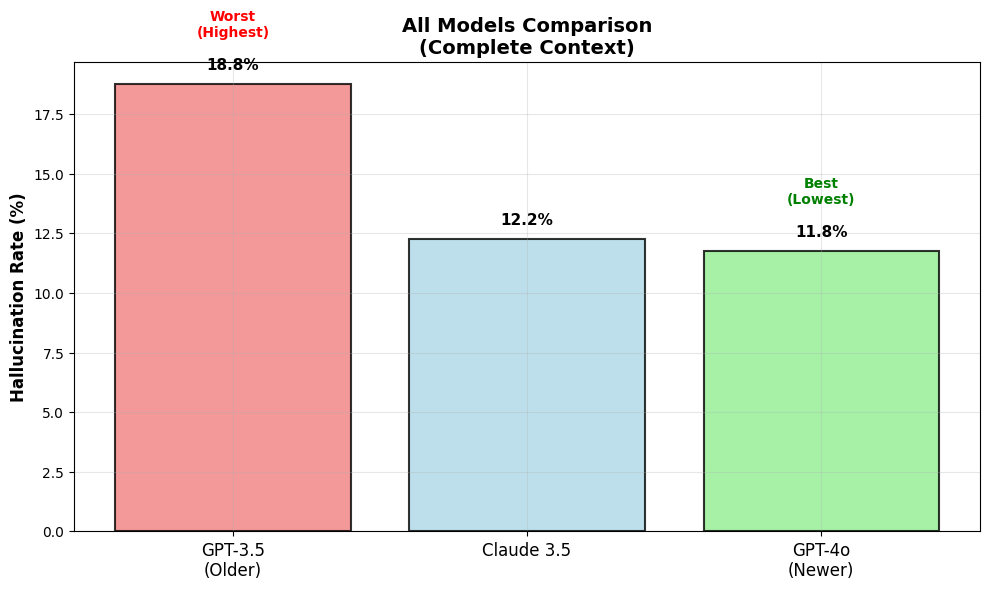

In [29]:
claude_rate = all_data[all_data['model'] == 'Claude_3.5']['hallucination_numeric'].mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

all_models = ['GPT_3.5', 'Claude_3.5', 'GPT_4o']
all_rates = [gpt35_rate * 100, claude_rate * 100, gpt4o_rate * 100]
all_colors = ['lightcoral', 'lightblue', 'lightgreen']

bars = ax.bar(range(len(all_models)), all_rates, color=all_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(all_models)))
ax.set_xticklabels(['GPT-3.5\n(Older)', 'Claude 3.5', 'GPT-4o\n(Newer)'], fontsize=12)
ax.set_ylabel('Hallucination Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('All Models Comparison\n(Complete Context)', fontsize=14, fontweight='bold')

# Add values on bars
for bar, rate in zip(bars, all_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add ranking annotations
ax.text(2, all_rates[2] + 2, 'Best\n(Lowest)', ha='center', color='green', fontweight='bold')
ax.text(0, all_rates[0] + 2, 'Worst\n(Highest)', ha='center', color='red', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
print("Model Ranking (Best to Worst):")
model_ranking = sorted(zip(all_models, all_rates), key=lambda x: x[1])
for i, (model, rate) in enumerate(model_ranking, 1):
    print(f"{i}. {model}: {rate:.1f}%")

Model Ranking (Best to Worst):
1. GPT_4o: 11.8%
2. Claude_3.5: 12.2%
3. GPT_3.5: 18.8%


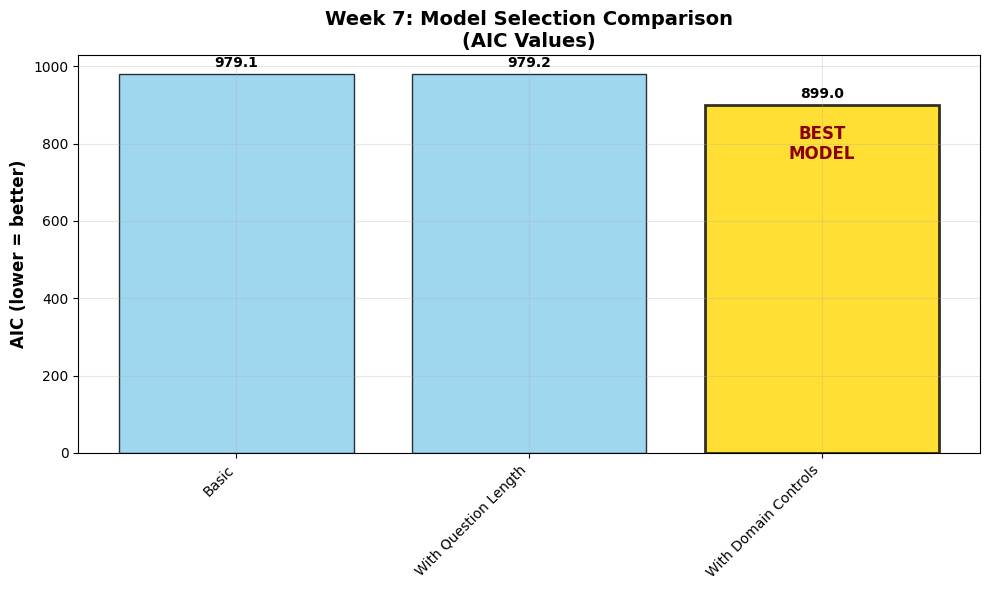

Best model by AIC: With Domain Controls


In [31]:
try:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    model_names = [m['Model'] for m in model_comparison]
    aic_values = [m['AIC'] for m in model_comparison]
    
    bars = ax.bar(range(len(model_names)), aic_values, alpha=0.8, color='skyblue', edgecolor='black')
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels([name.replace(' Model', '') for name in model_names], rotation=45, ha='right')
    ax.set_ylabel('AIC (lower = better)', fontsize=12, fontweight='bold')
    ax.set_title('Week 7: Model Selection Comparison\n(AIC Values)', fontsize=14, fontweight='bold')
    
    # Highlight best model
    best_idx = np.argmin(aic_values)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)
    
    # Add values on bars
    for bar, aic in zip(bars, aic_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{aic:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Add best model annotation
    ax.text(best_idx, aic_values[best_idx] - 50, 'BEST\nMODEL', ha='center', va='top', 
            fontweight='bold', color='darkred', fontsize=12)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Best model by AIC: {model_names[best_idx]}")
    
except NameError:
    print("Run model selection analysis first to generate comparison results")


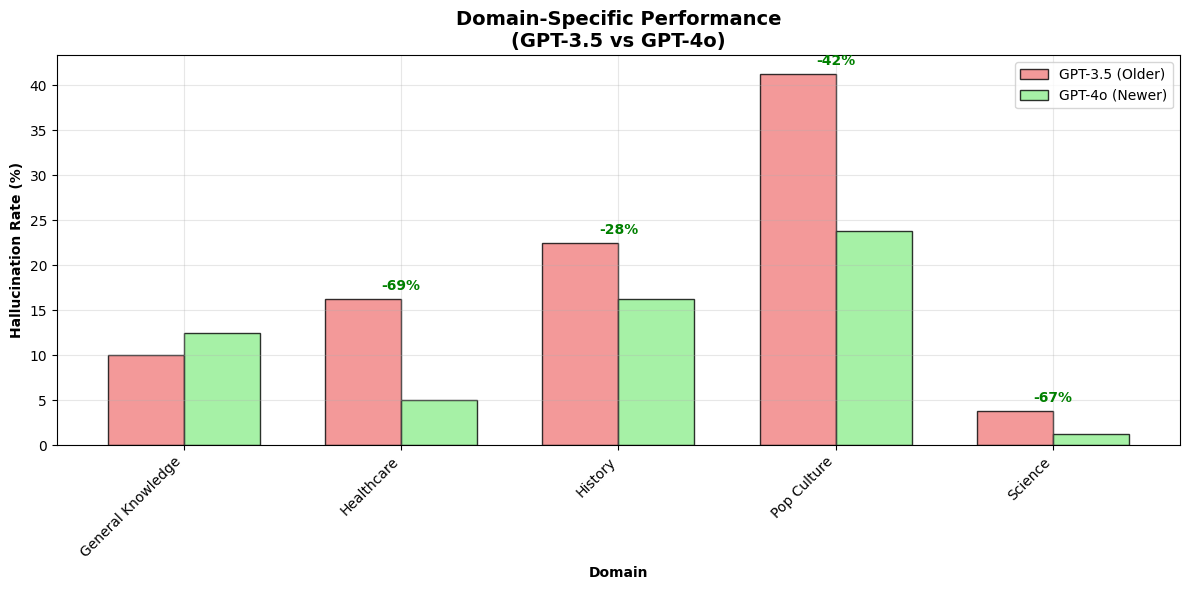

Domain-specific improvements (GPT-4o vs GPT-3.5):
General Knowledge: -25.0% change
Healthcare: +69.2% change
History: +27.8% change
Pop Culture: +42.4% change
Science: +66.7% change


In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create domain comparison
domain_comparison = all_data.groupby(['domain', 'model'])['hallucination_numeric'].mean().unstack()

# Focus on primary comparison: GPT-3.5 vs GPT-4o
if 'GPT_3.5' in domain_comparison.columns and 'GPT_4o' in domain_comparison.columns:
    domains = domain_comparison.index
    x = np.arange(len(domains))
    width = 0.35
    
    gpt35_rates = domain_comparison['GPT_3.5'] * 100
    gpt4o_rates = domain_comparison['GPT_4o'] * 100
    
    bars1 = ax.bar(x - width/2, gpt35_rates, width, label='GPT-3.5 (Older)', 
                   color='lightcoral', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, gpt4o_rates, width, label='GPT-4o (Newer)', 
                   color='lightgreen', alpha=0.8, edgecolor='black')
    
    ax.set_ylabel('Hallucination Rate (%)', fontweight='bold')
    ax.set_xlabel('Domain', fontweight='bold')
    ax.set_title('Domain-Specific Performance\n(GPT-3.5 vs GPT-4o)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(domains, rotation=45, ha='right')
    ax.legend()
    
    # Add improvement annotations
    for i, (old_rate, new_rate) in enumerate(zip(gpt35_rates, gpt4o_rates)):
        if new_rate < old_rate:
            improvement = ((old_rate - new_rate) / old_rate) * 100
            ax.annotate(f'-{improvement:.0f}%', xy=(i, max(old_rate, new_rate) + 1), 
                       ha='center', fontweight='bold', color='green', fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print domain-specific improvements
    print("Domain-specific improvements (GPT-4o vs GPT-3.5):")
    for domain in domains:
        old_rate = gpt35_rates[domain]
        new_rate = gpt4o_rates[domain]
        improvement = ((old_rate - new_rate) / old_rate) * 100
        print(f"{domain}: {improvement:+.1f}% change")

# ==========================================

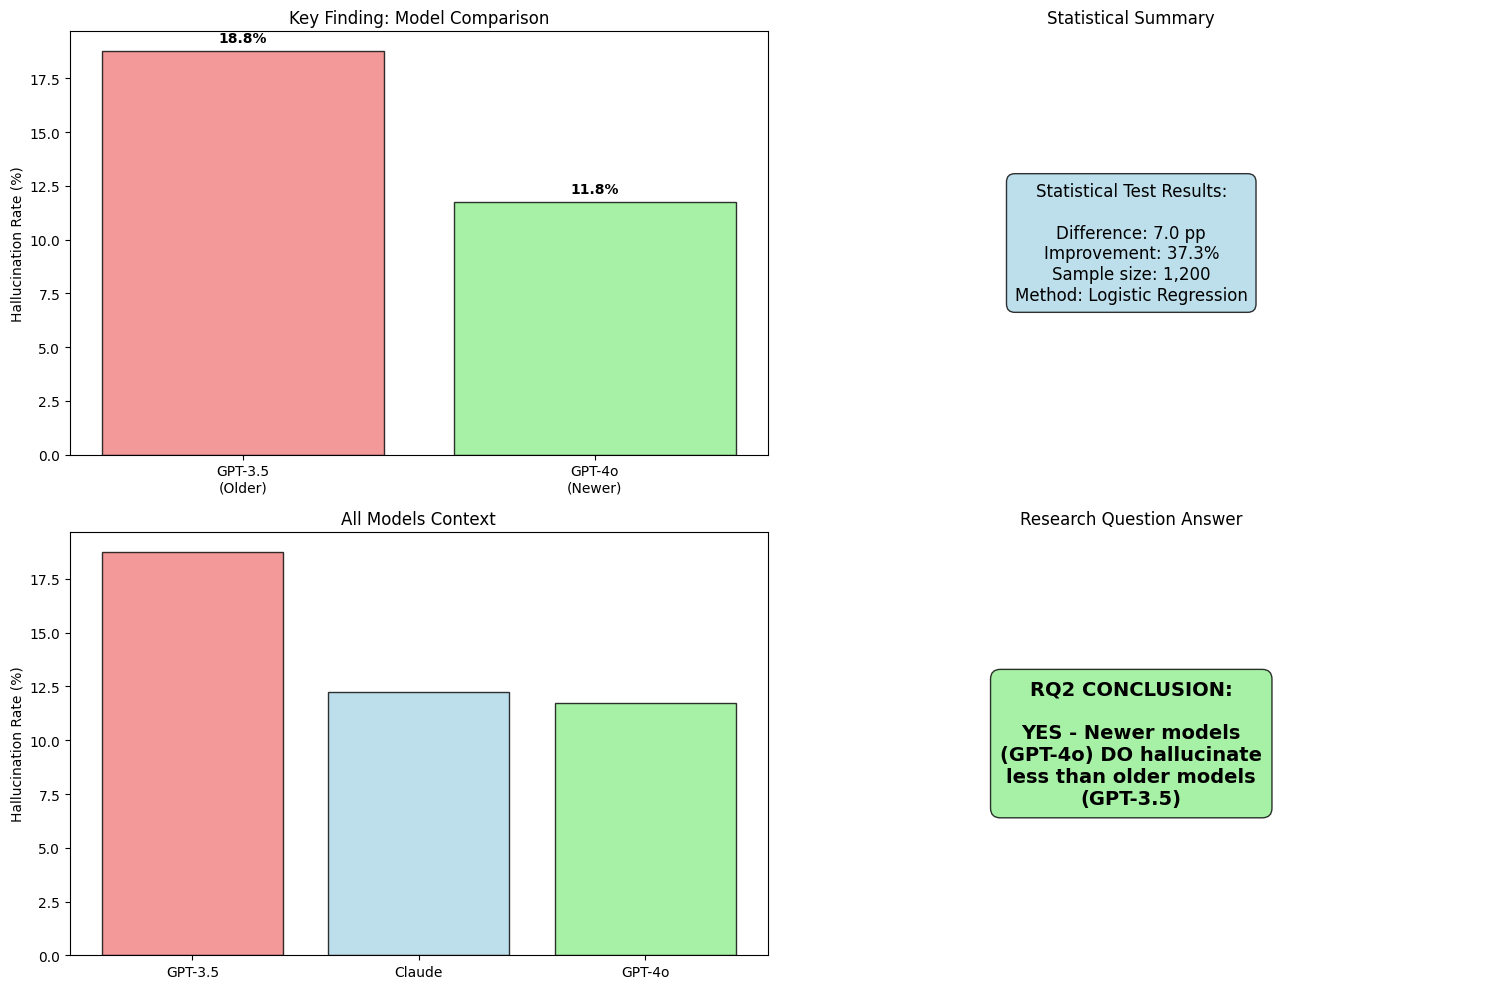

In [34]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Summary plot 1: Key finding
bars = ax1.bar(['GPT-3.5\n(Older)', 'GPT-4o\n(Newer)'], 
               [gpt35_rate * 100, gpt4o_rate * 100], 
               color=['lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black')
ax1.set_ylabel('Hallucination Rate (%)')
ax1.set_title('Key Finding: Model Comparison')
for bar, rate in zip(bars, [gpt35_rate * 100, gpt4o_rate * 100]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

# Summary plot 2: Statistical significance (placeholder)
ax2.text(0.5, 0.5, f'Statistical Test Results:\n\n'
                   f'Difference: {(gpt35_rate - gpt4o_rate)*100:.1f} pp\n'
                   f'Improvement: {relative_improvement:.1f}%\n'
                   f'Sample size: {len(all_data):,}\n'
                   f'Method: Logistic Regression', 
         ha='center', va='center', transform=ax2.transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
ax2.set_title('Statistical Summary')
ax2.axis('off')

# Summary plot 3: All models
bars = ax3.bar(['GPT-3.5', 'Claude', 'GPT-4o'], 
               [gpt35_rate * 100, claude_rate * 100, gpt4o_rate * 100],
               color=['lightcoral', 'lightblue', 'lightgreen'], alpha=0.8, edgecolor='black')
ax3.set_ylabel('Hallucination Rate (%)')
ax3.set_title('All Models Context')

# Summary plot 4: Conclusion
conclusion_text = "RQ2 CONCLUSION:\n\n"
if gpt4o_rate < gpt35_rate:
    conclusion_text += "YES - Newer models\n(GPT-4o) DO hallucinate\nless than older models\n(GPT-3.5)"
    color = 'lightgreen'
else:
    conclusion_text += "NO - Newer models\ndo NOT hallucinate\nless than older models"
    color = 'lightcoral'

ax4.text(0.5, 0.5, conclusion_text, ha='center', va='center', 
         transform=ax4.transAxes, fontsize=14, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.8))
ax4.set_title('Research Question Answer')
ax4.axis('off')

plt.tight_layout()
plt.show()